# Visualization

In [1]:
%load_ext autoreload
%autoreload 2 

import helpers
import config

import torch
import torch.nn as nn
import numpy as np

from models.BasicNet import BasicNet
from train import train_basic
from predict import predict_basic

from models.CNN import CNN
from models.FCN import FCN 

from models.SiameseNet import SiameseNet
from train import train_siamese
from predict import predict_siamese

import torch.utils.data as data
import matplotlib.pyplot as plt
from datasets import PairDataset
from torchsummary import summary

In [2]:
rounds = 10 

## Load data

In [3]:
pairs = helpers.generate_pair_sets(config.NB_SAMPLES)

train_dataset = PairDataset(pairs[0], pairs[1], pairs[2])
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size= config.TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = PairDataset(pairs[3], pairs[4], pairs[5])
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=config.TEST_BATCH_SIZE, shuffle=True)

## Plot

### Basic Net

In [4]:
summary(BasicNet(), (1 ,2, 14, 14)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         201,216
            Linear-2                    [-1, 1]             513
Total params: 201,729
Trainable params: 201,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.77
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [ ]:
round_results = [] #3D
    
for i in range(rounds):
    print("Round {0}".format(i))

    results = [] #training_losses, training_acc, test_losses, test_acc
    
    model = BasicNet()
    
    training_losses, training_acc, test_losses, test_acc = train_basic(model, train_dataloader, test_dataloader, epochs = config.EPOCHS,  learning_rate= 0.00001)

    results.append([training_losses, training_acc, test_losses, test_acc])
              
    print("With {0} batch size and {1} epochs and {2} learning rate we get :".format(config.TRAIN_BATCH_SIZE, config.EPOCHS, config.LEARNING_RATE))
    
    final_test_loss, final_test_loss_acc = predict_basic(model, test_dataloader)
    print("On the test set we obtain a loss of {:.2f} and an accuracy of {:.2f}".format(final_test_loss,final_test_loss_acc))
      
    round_results.append(results)

In [ ]:
means = np.array(round_results).mean(axis= 0).reshape((4,20))
std  = np.array(round_results).std(axis = 0).reshape((4,20))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (14,8))

ax1.plot(means[0], color = 'r', label = 'training loss')
ax1.plot(means[2], color = 'b',  linestyle='dashed', label = 'test loss')
        
ax1.fill_between(range(len(means[0])), means[0] - std[0], means[0] + std[0], alpha = 0.2, color = 'r')
ax1.fill_between(range(len(means[2])), means[2] - std[2], means[2] + std[2], alpha = 0.2, color = 'b')

ax2.plot(means[1], color = 'r', label = 'training accuracy')
ax2.plot(means[3], color = 'b', linestyle='dashed', label = 'test accuracy')

ax2.fill_between(range(len(means[1])), means[1]- std[1], means[1]+ std[1], alpha = 0.2, color = 'r')
ax2.fill_between(range(len(means[3])), means[3]- std[3], means[3]+ std[3], alpha = 0.2, color = 'b')

ax1.set_title('Training Binary Cross Entropy Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("BCE")

ax2.set_title('Training accuracy}')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

ax1.legend(loc = 'upper right')
ax2.legend(loc = 'lower right')
plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)
plt.show()

### Siamese Net

We want to assess the difference w/o aux loss and weight sharing for each subnet configuration

In [5]:
configuration = [
    (weight_sharing, aux_loss)
    
    for weight_sharing in [False,True]
    for aux_loss in [False,True]
]
configuration

[(False, False), (False, True), (True, False), (True, True)]

In [6]:
def compute_results_fcn(subnet_type, nb_hidden_layers = config.FCN_NB_HIDDEN, 
                    hidden_layer = config.FCN_HIDDEN_LAYER,
                    nb_hidden_layers_out = config.SIAMESE_NET_NB_HIDDEN,
                    hidden_layer_out = config.SIAMESE_NET_HIDDEN_LAYER,
                    alpha = config.ALPHA): 

    round_results = []

    for i in range(rounds):
        results = [] #training_losses, training_acc, test_losses, test_acc
        
        for weight_sharing, aux_loss in configuration:
            subnet1 = FCN(nb_hidden_layers, hidden_layer)
            subnet2 = FCN(nb_hidden_layers, hidden_layer)
            
            print('Model for weight_sharing = {0} and aux loss = {1} on round {2} with subnet {3}'.format(weight_sharing, aux_loss, 
                                                                                                          i,subnet_type))
            
            if(weight_sharing):
                model = SiameseNet(subnet1, None, nb_hidden_layers_out, hidden_layer_out)
            else: 
                model = SiameseNet(subnet1, subnet2, nb_hidden_layers_out, hidden_layer_out)
            
            training_losses, training_acc, _, _, test_losses, test_acc, _, _ = train_siamese(
                    model = model, dataloader = train_dataloader, test_dataloader = test_dataloader, aux_loss = aux_loss, alpha = alpha)        
            
            final_test_loss, final_test_loss_acc, _, _ = predict_siamese(model, test_dataloader, aux_loss, alpha)
            print("In epoch 20, on the test set we obtain a loss of {:.2f} and an accuracy of {:.2f}".format(final_test_loss,final_test_loss_acc))
            results.append([training_losses, training_acc, test_losses, test_acc])

        round_results.append(results)

    return round_results

In [7]:
def compute_results_cnn(subnet_type, nb_hidden_layers = config.CNN_NB_HIDDEN, 
                    base_channel_size = config.CNN_BASE_CHANNEL_SIZE, 
                    hidden_layer = config.CNN_HIDDEN_LAYER,
                    kernel_size = config.CNN_KERNEL_SIZE,
                    nb_hidden_layers_out = config.SIAMESE_NET_NB_HIDDEN,
                    hidden_layer_out = config.SIAMESE_NET_HIDDEN_LAYER,
                    alpha = config.ALPHA): 

    round_results = []

    for i in range(rounds):
        results = [] #training_losses, training_acc, test_losses, test_acc
        
        for weight_sharing, aux_loss in configuration:
            subnet1 = CNN(nb_hidden_layers, base_channel_size, hidden_layer, kernel_size)
            subnet2 = CNN(nb_hidden_layers, base_channel_size, hidden_layer, kernel_size)
            
            print('Model for weight_sharing = {0} and aux loss = {1} on round {2} with subnet {3}'.format(weight_sharing, aux_loss, 
                                                                                                          i,subnet_type))
            
            if(weight_sharing):
                model = SiameseNet(subnet1, None, nb_hidden_layers_out, hidden_layer_out)
            else: 
                model = SiameseNet(subnet1, subnet2, nb_hidden_layers_out, hidden_layer_out)
            
            training_losses, training_acc, _, _, test_losses, test_acc, _, _ = train_siamese(
                    model = model, dataloader = train_dataloader, test_dataloader = test_dataloader, aux_loss = aux_loss, alpha = alpha)        
            
            final_test_loss, final_test_loss_acc, _, _ = predict_siamese(model, test_dataloader, aux_loss, alpha)
            print("In epoch 20, on the test set we obtain a loss of {:.2f} and an accuracy of {:.2f}".format(final_test_loss,final_test_loss_acc))
            results.append([training_losses, training_acc, test_losses, test_acc])

        round_results.append(results)

    return round_results

In [8]:
def plots_results(round_results, subnet_type):
    
    colors = ['b', 'g', 'r', 'm']

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (14,8))

    means = np.array(round_results).mean(axis= 0)
    std  = np.array(round_results).std(axis = 0)
    dict_word = {False :'without', True : 'with'}
    for i, (r,s,p) in enumerate( zip(means,std,configuration) ):

        ax1.plot(r[0], color = colors[i], label = 'training loss {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))
        ax1.plot(r[2], color = colors[i],  linestyle='dashed', label = 'test loss {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))

        ax1.fill_between(range(len(r[0])), r[0] - s[0], r[0]+ s[0], alpha = 0.2, color = colors[i])
        ax1.fill_between(range(len(r[2])), r[2]- s[2], r[2]+ s[2], alpha = 0.2, color = colors[i])

        ax2.plot(r[1], color = colors[i], label = 'training accuracy {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))
        ax2.plot(r[3], color = colors[i], linestyle='dashed', label = 'test accuracy {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))

        ax2.fill_between(range(len(r[1])), r[1]- s[1], r[1]+ s[1], alpha = 0.2, color = colors[i])
        ax2.fill_between(range(len(r[3])), r[3]- s[3], r[3]+ s[3], alpha = 0.2, color = colors[i])

    ax1.set_title('Training Binary Cross Entropy with {0} subnets'.format(subnet_type))
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("BCE")

    ax2.set_title('Training accuracy with {0} subnets'.format(subnet_type))
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")

    ax1.legend(loc = 'upper right')
    ax2.legend(loc = 'lower right')
    plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)
    plt.show()

#### Subnets : FCN 

In [14]:
FCN()

FCN(
  (hiddens): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=196, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.2)
    )
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
round_results_FCN = compute_results_fcn('FCN')

Model for weight_sharing = False and aux loss = False on round 0 with subnet FCN
At epoch 1 the training loss is 0.7393079074472189
At epoch 1 the training accuracy is 0.652
epoch 1/20
The test loss is 0.5059962868690491
The test accuracy is 0.76
At epoch 2 the training loss is 0.5168883879110218
At epoch 2 the training accuracy is 0.758
epoch 2/20
The test loss is 0.4662361741065979
The test accuracy is 0.757
At epoch 3 the training loss is 0.4196923411078751
At epoch 3 the training accuracy is 0.808
epoch 3/20
The test loss is 0.4872288107872009
The test accuracy is 0.764
At epoch 4 the training loss is 0.3800339947408065
At epoch 4 the training accuracy is 0.822
epoch 4/20
The test loss is 0.5599991679191589
The test accuracy is 0.749
At epoch 5 the training loss is 0.3116641235677525
At epoch 5 the training accuracy is 0.853
epoch 5/20
The test loss is 0.48571696877479553
The test accuracy is 0.805
At epoch 6 the training loss is 0.27208087985171003
At epoch 6 the training accuracy

At epoch 7 the training loss is 0.20834663758869282
At epoch 7 the training accuracy is 0.918
epoch 7/20
The test loss is 0.452541708946228
The test accuracy is 0.832
At epoch 8 the training loss is 0.18309853260609088
At epoch 8 the training accuracy is 0.935
epoch 8/20
The test loss is 0.4670111835002899
The test accuracy is 0.839
At epoch 9 the training loss is 0.16516209988991248
At epoch 9 the training accuracy is 0.937
epoch 9/20
The test loss is 0.5160320401191711
The test accuracy is 0.846
At epoch 10 the training loss is 0.13078398645066044
At epoch 10 the training accuracy is 0.951
epoch 10/20
The test loss is 0.5381818413734436
The test accuracy is 0.826
At epoch 11 the training loss is 0.12310212419010441
At epoch 11 the training accuracy is 0.958
epoch 11/20
The test loss is 0.6532536745071411
The test accuracy is 0.828
At epoch 12 the training loss is 0.11904867043194826
At epoch 12 the training accuracy is 0.95
epoch 12/20
The test loss is 0.5515719652175903
The test acc

At epoch 13 the training loss is 0.08190396968368077
At epoch 13 the training accuracy is 0.963
epoch 13/20
The test loss is 0.7695744633674622
The test accuracy is 0.812
At epoch 14 the training loss is 0.05675088315643279
At epoch 14 the training accuracy is 0.985
epoch 14/20
The test loss is 0.8922586441040039
The test accuracy is 0.813
At epoch 15 the training loss is 0.04105954046661736
At epoch 15 the training accuracy is 0.983
epoch 15/20
The test loss is 0.9411971569061279
The test accuracy is 0.815
At epoch 16 the training loss is 0.05581715396619984
At epoch 16 the training accuracy is 0.98
epoch 16/20
The test loss is 0.9223330020904541
The test accuracy is 0.821
At epoch 17 the training loss is 0.03506736697081237
At epoch 17 the training accuracy is 0.987
epoch 17/20
The test loss is 0.9986118674278259
The test accuracy is 0.807
At epoch 18 the training loss is 0.032635531198201305
At epoch 18 the training accuracy is 0.987
epoch 18/20
The test loss is 1.0747703313827515
T

At epoch 19 the training loss is 0.04619333438964077
At epoch 19 the training accuracy is 0.983
epoch 19/20
The test loss is 0.7258889675140381
The test accuracy is 0.825
At epoch 20 the training loss is 0.03953864349729997
At epoch 20 the training accuracy is 0.987
epoch 20/20
The test loss is 0.7243123650550842
The test accuracy is 0.826
The test loss is 0.7243126034736633
The test accuracy is 0.826
In epoch 20, on the test set we obtain a loss of 0.72 and an accuracy of 0.83
Model for weight_sharing = True and aux loss = True on round 1 with subnet FCN
At epoch 1 the training loss is 2.0452853564918043
At epoch 1 the training accuracy is 0.635
epoch 1/20
The test loss is 0.7117941379547119
The test accuracy is 0.742
At epoch 2 the training loss is 0.7140974137932062
At epoch 2 the training accuracy is 0.721
epoch 2/20
The test loss is 0.5653049349784851
The test accuracy is 0.762
At epoch 3 the training loss is 0.516274518109858
At epoch 3 the training accuracy is 0.801
epoch 3/20
T

At epoch 4 the training loss is 0.4567224832996726
At epoch 4 the training accuracy is 0.822
epoch 4/20
The test loss is 0.5961101651191711
The test accuracy is 0.803
At epoch 5 the training loss is 0.39627313283272086
At epoch 5 the training accuracy is 0.863
epoch 5/20
The test loss is 0.5255451202392578
The test accuracy is 0.829
At epoch 6 the training loss is 0.35827567664906385
At epoch 6 the training accuracy is 0.853
epoch 6/20
The test loss is 0.5009379386901855
The test accuracy is 0.845
At epoch 7 the training loss is 0.3190236548800021
At epoch 7 the training accuracy is 0.866
epoch 7/20
The test loss is 0.5110652446746826
The test accuracy is 0.841
At epoch 8 the training loss is 0.27216014329344035
At epoch 8 the training accuracy is 0.902
epoch 8/20
The test loss is 0.49643629789352417
The test accuracy is 0.847
At epoch 9 the training loss is 0.24310219798237084
At epoch 9 the training accuracy is 0.907
epoch 9/20
The test loss is 0.5041477680206299
The test accuracy is

At epoch 10 the training loss is 0.2201381651009433
At epoch 10 the training accuracy is 0.901
epoch 10/20
The test loss is 0.41294577717781067
The test accuracy is 0.85
At epoch 11 the training loss is 0.1911830047436524
At epoch 11 the training accuracy is 0.92
epoch 11/20
The test loss is 0.41136837005615234
The test accuracy is 0.861
At epoch 12 the training loss is 0.19023623025976122
At epoch 12 the training accuracy is 0.928
epoch 12/20
The test loss is 0.4058113694190979
The test accuracy is 0.878
At epoch 13 the training loss is 0.1586607635789551
At epoch 13 the training accuracy is 0.931
epoch 13/20
The test loss is 0.3986474573612213
The test accuracy is 0.88
At epoch 14 the training loss is 0.15422724080155603
At epoch 14 the training accuracy is 0.937
epoch 14/20
The test loss is 0.3875548839569092
The test accuracy is 0.869
At epoch 15 the training loss is 0.14508993830066175
At epoch 15 the training accuracy is 0.944
epoch 15/20
The test loss is 0.42006075382232666
The 

At epoch 16 the training loss is 0.1321409763515112
At epoch 16 the training accuracy is 0.951
epoch 16/20
The test loss is 0.5810338258743286
The test accuracy is 0.849
At epoch 17 the training loss is 0.13313501518918203
At epoch 17 the training accuracy is 0.949
epoch 17/20
The test loss is 0.5644599199295044
The test accuracy is 0.848
At epoch 18 the training loss is 0.12957802274031566
At epoch 18 the training accuracy is 0.949
epoch 18/20
The test loss is 0.593075156211853
The test accuracy is 0.845
At epoch 19 the training loss is 0.11205479521362577
At epoch 19 the training accuracy is 0.961
epoch 19/20
The test loss is 0.6022021770477295
The test accuracy is 0.853
At epoch 20 the training loss is 0.09357829953311012
At epoch 20 the training accuracy is 0.97
epoch 20/20
The test loss is 0.6092203855514526
The test accuracy is 0.851
The test loss is 0.6092203855514526
The test accuracy is 0.851
In epoch 20, on the test set we obtain a loss of 0.61 and an accuracy of 0.85
Model f

At epoch 1 the training loss is 0.7478706769645214
At epoch 1 the training accuracy is 0.619
epoch 1/20
The test loss is 0.5690346956253052
The test accuracy is 0.74
At epoch 2 the training loss is 0.5689088792726398
At epoch 2 the training accuracy is 0.706
epoch 2/20
The test loss is 0.4690438210964203
The test accuracy is 0.779
At epoch 3 the training loss is 0.4298649590276182
At epoch 3 the training accuracy is 0.81
epoch 3/20
The test loss is 0.4425815939903259
The test accuracy is 0.772
At epoch 4 the training loss is 0.38077195655554535
At epoch 4 the training accuracy is 0.847
epoch 4/20
The test loss is 0.46803146600723267
The test accuracy is 0.793
At epoch 5 the training loss is 0.33102725432254376
At epoch 5 the training accuracy is 0.859
epoch 5/20
The test loss is 0.47227197885513306
The test accuracy is 0.779
At epoch 6 the training loss is 0.29289410458877685
At epoch 6 the training accuracy is 0.879
epoch 6/20
The test loss is 0.4357999563217163
The test accuracy is 0

At epoch 7 the training loss is 0.22314427216799232
At epoch 7 the training accuracy is 0.911
epoch 7/20
The test loss is 0.40895867347717285
The test accuracy is 0.828
At epoch 8 the training loss is 0.19533901522110683
At epoch 8 the training accuracy is 0.919
epoch 8/20
The test loss is 0.4232400953769684
The test accuracy is 0.833
At epoch 9 the training loss is 0.15629882450215518
At epoch 9 the training accuracy is 0.942
epoch 9/20
The test loss is 0.4933384358882904
The test accuracy is 0.847
At epoch 10 the training loss is 0.13277079612236775
At epoch 10 the training accuracy is 0.944
epoch 10/20
The test loss is 0.507725715637207
The test accuracy is 0.834
At epoch 11 the training loss is 0.12405042732127186
At epoch 11 the training accuracy is 0.952
epoch 11/20
The test loss is 0.5531426668167114
The test accuracy is 0.828
At epoch 12 the training loss is 0.10872806111285171
At epoch 12 the training accuracy is 0.953
epoch 12/20
The test loss is 0.5599955916404724
The test a

At epoch 13 the training loss is 0.10892011424350585
At epoch 13 the training accuracy is 0.971
epoch 13/20
The test loss is 0.7456555962562561
The test accuracy is 0.814
At epoch 14 the training loss is 0.07377061343066402
At epoch 14 the training accuracy is 0.979
epoch 14/20
The test loss is 0.8595182299613953
The test accuracy is 0.811
At epoch 15 the training loss is 0.0631817041602153
At epoch 15 the training accuracy is 0.977
epoch 15/20
The test loss is 0.8680899143218994
The test accuracy is 0.814
At epoch 16 the training loss is 0.048989619662161206
At epoch 16 the training accuracy is 0.985
epoch 16/20
The test loss is 0.9319078922271729
The test accuracy is 0.811
At epoch 17 the training loss is 0.04534396266276758
At epoch 17 the training accuracy is 0.982
epoch 17/20
The test loss is 0.9933750033378601
The test accuracy is 0.802
At epoch 18 the training loss is 0.041385192319777386
At epoch 18 the training accuracy is 0.984
epoch 18/20
The test loss is 1.0219216346740723


At epoch 19 the training loss is 0.057095414817371765
At epoch 19 the training accuracy is 0.979
epoch 19/20
The test loss is 0.6932911276817322
The test accuracy is 0.826
At epoch 20 the training loss is 0.04616938749740804
At epoch 20 the training accuracy is 0.982
epoch 20/20
The test loss is 0.7554112076759338
The test accuracy is 0.832
The test loss is 0.7554115056991577
The test accuracy is 0.832
In epoch 20, on the test set we obtain a loss of 0.76 and an accuracy of 0.83
Model for weight_sharing = True and aux loss = True on round 5 with subnet FCN
At epoch 1 the training loss is 2.617058802396059
At epoch 1 the training accuracy is 0.603
epoch 1/20
The test loss is 0.719611406326294
The test accuracy is 0.725
At epoch 2 the training loss is 0.7286272701621056
At epoch 2 the training accuracy is 0.72
epoch 2/20
The test loss is 0.5683844685554504
The test accuracy is 0.779
At epoch 3 the training loss is 0.5251909130066633
At epoch 3 the training accuracy is 0.781
epoch 3/20
Th

At epoch 4 the training loss is 0.46332337610423563
At epoch 4 the training accuracy is 0.827
epoch 4/20
The test loss is 0.5749256014823914
The test accuracy is 0.815
At epoch 5 the training loss is 0.380457288660109
At epoch 5 the training accuracy is 0.837
epoch 5/20
The test loss is 0.547642707824707
The test accuracy is 0.816
At epoch 6 the training loss is 0.33181561513338237
At epoch 6 the training accuracy is 0.865
epoch 6/20
The test loss is 0.5351967811584473
The test accuracy is 0.824
At epoch 7 the training loss is 0.2893493120186031
At epoch 7 the training accuracy is 0.876
epoch 7/20
The test loss is 0.5658791065216064
The test accuracy is 0.823
At epoch 8 the training loss is 0.2583060019742697
At epoch 8 the training accuracy is 0.893
epoch 8/20
The test loss is 0.515882134437561
The test accuracy is 0.847
At epoch 9 the training loss is 0.2562515207356773
At epoch 9 the training accuracy is 0.884
epoch 9/20
The test loss is 0.5378205180168152
The test accuracy is 0.845

At epoch 10 the training loss is 0.2202621806738898
At epoch 10 the training accuracy is 0.907
epoch 10/20
The test loss is 0.39041566848754883
The test accuracy is 0.885
At epoch 11 the training loss is 0.18404068040195853
At epoch 11 the training accuracy is 0.919
epoch 11/20
The test loss is 0.4317097067832947
The test accuracy is 0.881
At epoch 12 the training loss is 0.19069740959443152
At epoch 12 the training accuracy is 0.924
epoch 12/20
The test loss is 0.40931349992752075
The test accuracy is 0.881
At epoch 13 the training loss is 0.17284375089686363
At epoch 13 the training accuracy is 0.933
epoch 13/20
The test loss is 0.4009521007537842
The test accuracy is 0.879
At epoch 14 the training loss is 0.13635731931310147
At epoch 14 the training accuracy is 0.949
epoch 14/20
The test loss is 0.4127681851387024
The test accuracy is 0.885
At epoch 15 the training loss is 0.14571813937160186
At epoch 15 the training accuracy is 0.943
epoch 15/20
The test loss is 0.4303860068321228


At epoch 16 the training loss is 0.12272057568887249
At epoch 16 the training accuracy is 0.949
epoch 16/20
The test loss is 0.5343270897865295
The test accuracy is 0.848
At epoch 17 the training loss is 0.10972743271035142
At epoch 17 the training accuracy is 0.962
epoch 17/20
The test loss is 0.5372096300125122
The test accuracy is 0.852
At epoch 18 the training loss is 0.1023034581670072
At epoch 18 the training accuracy is 0.963
epoch 18/20
The test loss is 0.5413111448287964
The test accuracy is 0.851
At epoch 19 the training loss is 0.10694252267130651
At epoch 19 the training accuracy is 0.957
epoch 19/20
The test loss is 0.5565458536148071
The test accuracy is 0.845
At epoch 20 the training loss is 0.0887929175174213
At epoch 20 the training accuracy is 0.968
epoch 20/20
The test loss is 0.5539920330047607
The test accuracy is 0.854
The test loss is 0.5539922714233398
The test accuracy is 0.854
In epoch 20, on the test set we obtain a loss of 0.55 and an accuracy of 0.85
Model 

At epoch 1 the training loss is 0.7052346083894372
At epoch 1 the training accuracy is 0.659
epoch 1/20
The test loss is 0.556286096572876
The test accuracy is 0.705
At epoch 2 the training loss is 0.48995272900909187
At epoch 2 the training accuracy is 0.779
epoch 2/20
The test loss is 0.49344539642333984
The test accuracy is 0.773
At epoch 3 the training loss is 0.42064892876893284
At epoch 3 the training accuracy is 0.815
epoch 3/20
The test loss is 0.4286609888076782
The test accuracy is 0.81
At epoch 4 the training loss is 0.369250777522102
At epoch 4 the training accuracy is 0.823
epoch 4/20
The test loss is 0.42103490233421326
The test accuracy is 0.806
At epoch 5 the training loss is 0.2942794284131378
At epoch 5 the training accuracy is 0.867
epoch 5/20
The test loss is 0.5033354163169861
The test accuracy is 0.801
At epoch 6 the training loss is 0.25336106537375597
At epoch 6 the training accuracy is 0.9
epoch 6/20
The test loss is 0.5067257285118103
The test accuracy is 0.81

At epoch 7 the training loss is 0.24454821218343567
At epoch 7 the training accuracy is 0.916
epoch 7/20
The test loss is 0.3879701793193817
The test accuracy is 0.832
At epoch 8 the training loss is 0.19475258696737
At epoch 8 the training accuracy is 0.926
epoch 8/20
The test loss is 0.43964773416519165
The test accuracy is 0.838
At epoch 9 the training loss is 0.18674911855661777
At epoch 9 the training accuracy is 0.926
epoch 9/20
The test loss is 0.4016400873661041
The test accuracy is 0.829
At epoch 10 the training loss is 0.16815789050539023
At epoch 10 the training accuracy is 0.939
epoch 10/20
The test loss is 0.4562036097049713
The test accuracy is 0.829
At epoch 11 the training loss is 0.13537359208363342
At epoch 11 the training accuracy is 0.948
epoch 11/20
The test loss is 0.4657476842403412
The test accuracy is 0.844
At epoch 12 the training loss is 0.11443944158603245
At epoch 12 the training accuracy is 0.956
epoch 12/20
The test loss is 0.5364255309104919
The test acc

At epoch 13 the training loss is 0.090880171927638
At epoch 13 the training accuracy is 0.972
epoch 13/20
The test loss is 0.7442256808280945
The test accuracy is 0.808
At epoch 14 the training loss is 0.0697173144876433
At epoch 14 the training accuracy is 0.975
epoch 14/20
The test loss is 0.702200174331665
The test accuracy is 0.808
At epoch 15 the training loss is 0.05534719726071899
At epoch 15 the training accuracy is 0.978
epoch 15/20
The test loss is 0.752673327922821
The test accuracy is 0.822
At epoch 16 the training loss is 0.04985593621795133
At epoch 16 the training accuracy is 0.98
epoch 16/20
The test loss is 0.7009232044219971
The test accuracy is 0.821
At epoch 17 the training loss is 0.053311596347189155
At epoch 17 the training accuracy is 0.975
epoch 17/20
The test loss is 0.7617477178573608
The test accuracy is 0.809
At epoch 18 the training loss is 0.03289922852460677
At epoch 18 the training accuracy is 0.985
epoch 18/20
The test loss is 0.7973676919937134
The te

At epoch 19 the training loss is 0.05698265785235037
At epoch 19 the training accuracy is 0.983
epoch 19/20
The test loss is 0.7025703191757202
The test accuracy is 0.832
At epoch 20 the training loss is 0.05025427987753119
At epoch 20 the training accuracy is 0.98
epoch 20/20
The test loss is 0.7080746293067932
The test accuracy is 0.831
The test loss is 0.7080745697021484
The test accuracy is 0.831
In epoch 20, on the test set we obtain a loss of 0.71 and an accuracy of 0.83
Model for weight_sharing = True and aux loss = True on round 9 with subnet FCN
At epoch 1 the training loss is 2.609094800204039
At epoch 1 the training accuracy is 0.666
epoch 1/20
The test loss is 0.7539970874786377
The test accuracy is 0.767
At epoch 2 the training loss is 0.6907820031791926
At epoch 2 the training accuracy is 0.771
epoch 2/20
The test loss is 0.5519547462463379
The test accuracy is 0.784
At epoch 3 the training loss is 0.5175981609709561
At epoch 3 the training accuracy is 0.804
epoch 3/20
Th

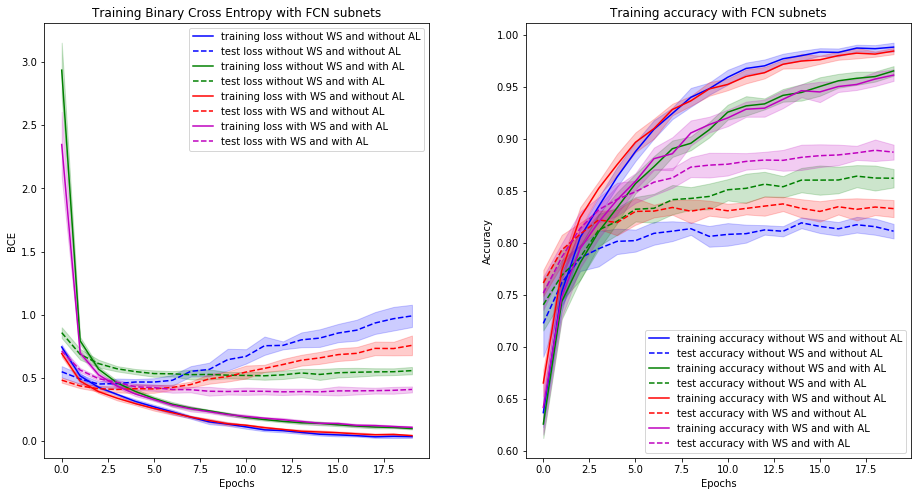

In [16]:
plots_results(round_results_FCN,'FCN')

In [17]:
means_FCN = np.array(round_results_FCN).mean(axis= 0)
means_FCN[:,3,19] #test_accuracy

array([0.8112, 0.8621, 0.8329, 0.8872])

In [18]:
std_FCN = np.array(round_results_FCN).std(axis= 0)
std_FCN[:,3,19] #test_accuracy

array([0.0069685 , 0.00884816, 0.00821523, 0.00716659])

#### Best FCN

In [ ]:
round_results_best_FCN = compute_results_fcn('FCN', nb_hidden_layers = config.FCN_BEST_NB, 
                                             hidden_layer = config.FCN_BEST_HIDDEN,
                                             nb_hidden_layers_out = config.SIAMESE_NET_BEST_NB_FCN, 
                                             hidden_layer_out = config.SIAMESE_NET_BEST_HIDDEN_FCN, 
                                             alpha = config.BEST_ALPHA_FCN)

Model for weight_sharing = False and aux loss = False on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.99 and an accuracy of 0.83
Model for weight_sharing = False and aux loss = True on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.51 and an accuracy of 0.91
Model for weight_sharing = True and aux loss = False on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.55 and an accuracy of 0.87
Model for weight_sharing = True and aux loss = True on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.34 and an accuracy of 0.93
Model for weight_sharing = False and aux loss = False on round 1 with subnet FCN
In epoch 20, on the test set we obtain a loss of 1.12 and an accuracy of 0.82
Model for weight_sharing = False and aux loss = True on round 1 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.43 and an accuracy of 0.90
Model for weight_sharing = True and aux loss = Fals

In [ ]:
means_best_FCN = np.array(round_results_best_FCN).mean(axis= 0)
means_best_FCN[:,3,19] #test_accuracy

In [ ]:
std_best_FCN = np.array(round_results_best_FCN).std(axis= 0)
std_best_FCN[:,3,19] #test_accuracy

#### Subnet : CNN

In [ ]:
CNN()

In [ ]:
round_results_CNN = compute_results_cnn('CNN')

In [ ]:
plots_results(round_results_CNN, 'CNN')

In [ ]:
means_CNN = np.array(round_results_CNN).mean(axis= 0)
means_CNN[:,3,19] #test_accuracy

In [ ]:
std_CNN = np.array(round_results_CNN).std(axis= 0)
std_CNN[:,3,19] #test_accuracy

#### Best CNN

In [ ]:
round_results_best_CNN = compute_results_cnn('CNN', nb_hidden_layers = config.CNN_BEST_NB, 
                                            base_channel_size = config.CNN_BEST_CHANNEL, 
                                            hidden_layer = config.CNN_BEST_HIDDEN,
                                            kernel_size = config.CNN_BEST_KERNEL_SIZE,
                                            nb_hidden_layers_out = config.SIAMESE_NET_BEST_NB_CNN,
                                            hidden_layer_out = config.SIAMESE_NET_BEST_HIDDEN_CNN,
                                            alpha = config.BEST_ALPHA_CNN)

In [ ]:
plots_results(round_results_best_CNN, 'CNN')

In [ ]:
means_best_CNN = np.array(round_results_best_CNN).mean(axis= 0)
means_best_CNN[:,3,19] #test_accuracy

In [ ]:
std_best_CNN = np.array(round_results_best_CNN).std(axis= 0)
std_best_CNN[:,3,19] #test_accuracy